<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg_eig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
%reset -f

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。

### べき乗法

ランダム行列を作成

A=


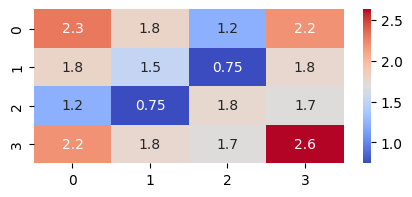

In [346]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
A = A.T @ A
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

べき乗法では対象の行列$A$のべき乗で最大固有値とその固有ベクトルを求める。

$A(A^{\infty}\vec{x})=\lambda(A^{\infty}\vec{x})$となることを利用する。

In [347]:
def power_iteration(A_, eps=1e-6, max_iter=100):
  A = A_.copy()
  x = (_ := np.random.rand(N)) / np.linalg.norm(_)
  lambda_ = 0
  for i in range(max_iter):
    # べき乗：反復毎に最大固有値の固有ベクトル成分が大きく
    v = A @ x
    # 最終的に(x,Ax)=(x,λx)=λとなるはず
    lambda_ = np.dot(x, v)
    x = v / np.linalg.norm(v)
    if np.dot(v, v) - lambda_ ** 2 < eps:
      print(f"early stop: {i=}")
      break
  return lambda_, x

lambda_, x = power_iteration(A)

print(f"{lambda_=:.3}")
print(f"{x=}")
print(f"{A@x-lambda_*x=}")

early stop: i=4
lambda_=6.97
x=array([0.549, 0.43 , 0.386, 0.604])
A@x-lambda_*x=array([ 1.740e-05,  2.373e-05, -4.167e-05, -6.052e-06])


### QR 分解

最も基本的な QR 分解はグラム・シュミットの直交化を利用

Q @ Q.T=


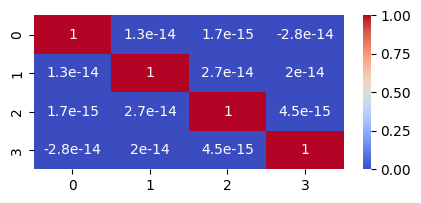

In [348]:
def gram_schmidt(vec_in_):
  vec_in = vec_in_.copy()
  vec_out = np.zeros_like(vec_in)
  # 各列を各ベクトルとみなす
  for k in range(vec_in.shape[1]):
    # 直交化の対象
    u = vec_in[:, k]
    # それまでに直交化したベクトルの成分を差し引く
    for j in range(k):
      u -= np.dot(vec_in[:, k], vec_out[:, j]) * vec_out[:, j]
    vec_out[:, k] = u / np.linalg.norm(u)
  return vec_out

Q = gram_schmidt(A)

# 直交行列になっているか確認
print("Q @ Q.T=")
sns.heatmap(Q @ Q.T, annot=True, cmap='coolwarm')
plt.show()

対象の正則行列$A$の各列を一次独立なベクトルとみなして、グラム・シュミットで直交化。

直交化したベクトルを並べたものを行列$Q$として、$A=QR$となるように行列$R$を構成。

Q=


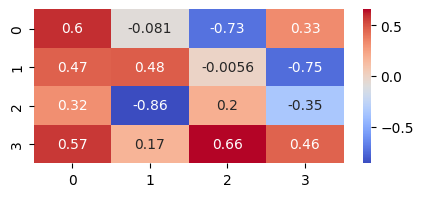

R=


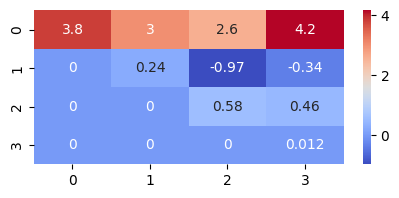

A-QR=


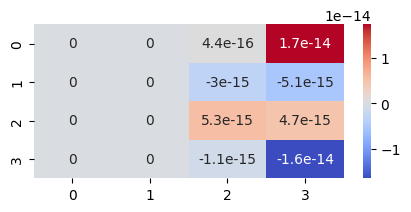

In [349]:
def QR_decomp(A_):
  A = A_.copy()
  # グラム・シュミットの直交化 -> Q を計算
  Q = gram_schmidt(A)

  R = np.zeros_like(A)
  for j in range(len(A)):
    # 上三角行列を計算 (j<=k)
    for k in range(j, len(A)):
      if j == k:
        a_k = A[:, k]
        for l in range(j):
          a_k -= np.dot(A[:, k], Q[:, l]) * Q[:, l]
        R[j, k] = np.linalg.norm(a_k)
      else:
        R[j, k] = np.dot(A[:, k], Q[:, j])
  return Q, R

Q, R = QR_decomp(A)

print("Q=")
sns.heatmap(Q, annot=True, cmap='coolwarm')
plt.show()

print("R=")
sns.heatmap(R, annot=True, cmap='coolwarm')
plt.show()

print("A-QR=")
sns.heatmap(A-Q@R, annot=True, cmap='coolwarm')
plt.show()

QR 法は QR 分解を繰り返して固有値を対角成分に持つ行列を作成。

$A_k=Q_kR_k, A_{k+1}=R_kQ_k=Q_k^{-1}AQ_k=Q_k^TAQ_k$を繰り返して、直交変換。

early stop: i=8
diag_A=


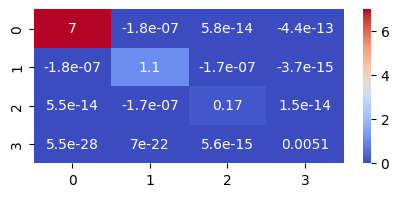

In [350]:
def QR_iteration(A_, eps=1e-6, max_iter=100):
  A = A_.copy()
  for i in range(max_iter):
    Q, R = QR_decomp(A)
    A = R @ Q
    if np.tril(np.abs(A), -1).max() < eps:
      print(f"early stop: {i=}")
      break
  return A

diag_A = QR_iteration(A)
print("diag_A=")
sns.heatmap(diag_A, annot=True, cmap='coolwarm')
plt.show()

In [351]:
def ordered_eigh(A):
  evalues, evectors = np.linalg.eigh(A)
  # 固有値の絶対値が大きい順に並べる
  idx = np.abs(evalues).argsort()[::-1]
  evalues = evalues[idx]
  evectors = evectors[:, idx]
  return evalues, evectors

evalues_np, evectors_np = ordered_eigh(A)

print(f"{np.diag(diag_A)=}")
print(f"{evalues_np=}")
print(f"residuals={np.diag(diag_A)-evalues_np}")

np.diag(diag_A)=array([6.970e+00, 1.076e+00, 1.669e-01, 5.085e-03])
evalues_np=array([6.970e+00, 1.076e+00, 1.669e-01, 5.085e-03])
residuals=[-5.329e-15 -2.953e-14  4.682e-14 -8.812e-16]


### 原点シフト

QR 法の収束速度は近似固有値と最小固有値の比で決定されるため、
最小固有値を小さくすると収束が早くなる。
そこで最小固有値（の近似値）を$\mu_k$として
\begin{equation}
A_k-\mu_k I=Q_kR_k,\quad
A_{k+1}=R_kQ_k+\mu_kI
\end{equation}
と反復する。

ウィルキンソンの移動法は$A_k$右下隅の2x2小行列の固有値のうち、
$A_k$の右下隅の値に近いほうを$\mu_k$として利用。

In [352]:
def minimal_eigh(A):
  if A.shape != (2, 2):
    raise ValueError("A must be 2x2 matrix")
  b = np.trace(A)
  c = np.linalg.det(A)
  D = b**2-4*c
  return np.array([(b+np.sqrt(D))/2, (b-np.sqrt(D))/2])

def wilkinson_shift(A):
  evalues = minimal_eigh(A[-2:, -2:])
  idx = np.argmin(np.abs(evalues-A[-1,-1]))
  return evalues[idx]

print(f"{wilkinson_shift(A)=:.2f}")

wilkinson_shift(A)=3.95


diag_A=


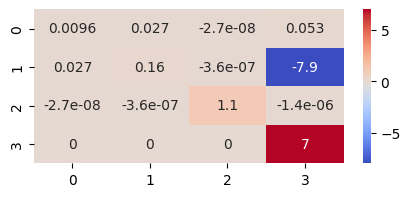

residuals=[-6.961 -0.914  0.91   6.965]


In [353]:
def shifted_QR_iteration(A_, eps=1e-6, max_iter=100):
  A = A_.copy()
  N = A.shape[0]
  for i in range(max_iter):
    mu = wilkinson_shift(A)
    Q, R = QR_decomp(A-mu*np.eye(N))
    A = R @ Q + mu*np.eye(N)
    if np.tril(np.abs(A), -1).max() < eps:
      print(f"early stop: {i=}")
      break
  return A

diag_A = shifted_QR_iteration(A)

print("diag_A=")
sns.heatmap(diag_A, annot=True, cmap='coolwarm')
plt.show()
print(f"residuals={np.diag(diag_A)-evalues_np}")

### 逆反復法

使用する変数を整理

A=


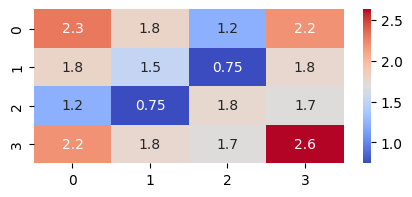

evalues=array([0.01 , 0.162, 1.076, 6.97 ])


In [354]:
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

evalues = np.diag(diag_A)
print(f"{evalues=}")

逆反復法は近似固有値$\lambda'$に対する$((A-\lambda'E)^{-1})^\infty$を固有ベクトルとして計算する方法。

計算の過程でレイリー商による計算
\begin{equation}
R(\vec{x}^{(k)})=\frac{(\vec{x}^{(k)},(A-\lambda'E)^{-1}\vec{x}^{(k)})}{(\vec{x}^{(k)},\vec{x}^{(k)})}
=\frac{1}{\lambda-\lambda'}\equiv\mu
\end{equation}
で固有値の高精度化が図れる。

residuals=


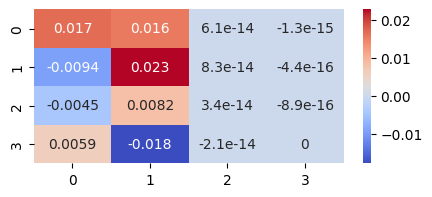

In [355]:
def inverse_iteration(A, evalues_, eps = 1e-6, max_iter = 100):
  evalues = evalues_.copy()
  N = A.shape[0]

  evectors = np.eye(N)
  # 固有ベクトルの1,2,...番目
  for i in range(N):
    for _ in range(max_iter):
      # 固有ベクトル
      # 本来は LU 分解などで求めるが np.linalg.solve で省略
      v = np.linalg.solve(A-evalues[i] * np.eye(N), evectors[:, i])
      evectors[:, i] = v / np.linalg.norm(v)

      # 固有値を入力から高精度化
      mu = np.dot(evectors[:, i], v)
      evalues[i] += 1 / mu

      if np.linalg.norm(v) - mu**2 < eps:
        # print(f"early stop: {i=}")
        break
  return evalues, evectors

evalues, evectors = inverse_iteration(A, evalues)

# Ax=λx
lambda_mat = np.diag(evalues)
residuals = A @ evectors - evectors @ lambda_mat

print("residuals=")
sns.heatmap(residuals, annot=True, cmap='coolwarm')
plt.show()

計算結果を numpy による結果と比較

evalues=array([0.022, 0.188, 1.076, 6.97 ])
evalues_np=array([6.970e+00, 1.076e+00, 1.669e-01, 5.085e-03])
evectors=array([[-0.321, -0.62 , -0.339,  0.549],
       [ 0.746,  0.093, -0.462,  0.43 ],
       [ 0.354, -0.325,  0.811,  0.386],
       [-0.464,  0.708,  0.118,  0.604]])
evectors_np=array([[-0.549, -0.339, -0.674,  0.36 ],
       [-0.43 , -0.462,  0.179, -0.755],
       [-0.386,  0.811, -0.275, -0.342],
       [-0.604,  0.118,  0.662,  0.429]])
evalues-evalues_np=array([-6.948, -0.889,  0.91 ,  6.965])
residuals=


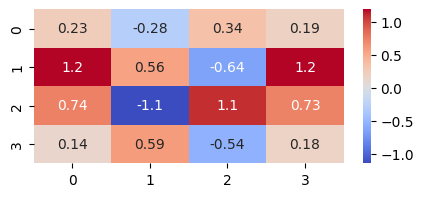

In [356]:
evalues_np, evectors_np = ordered_eigh(A)

# 符号を揃える
for idx in range(evectors_np.shape[1]):
  if evectors_np[0, idx] * evectors[0, idx] < 0 :
    evectors_np[:, idx] *= -1

print(f"{evalues=}")
print(f"{evalues_np=}")
print(f"{evectors=}")
print(f"{evectors_np=}")

print(f"{evalues-evalues_np=}")
print("residuals=")
sns.heatmap(evectors-evectors_np, annot=True, cmap='coolwarm')
plt.show()

## 固有値計算の高速化

### ハウスホルダー変換

対角成分より2以上左の成分が0となっている行列をヘッセンベルグ行列という。
QR 分解の前処理としてハウスホルダー変換と呼ばれる直交・鏡映変換で、
対象行列をヘッセンベルグ行列へ変換する。

P.T @ P=


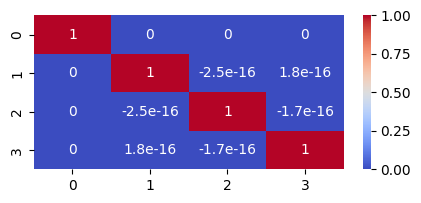

H=


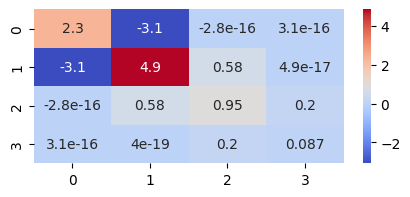

P.T@A@P-H=


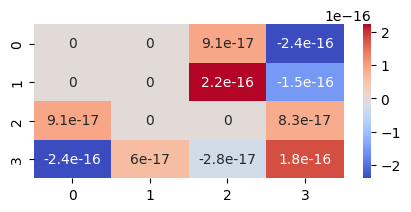

In [357]:
def householder(b):
  e = np.zeros_like(b)
  e[0] = 1
  # 桁落ち対策で異符号に
  s = -np.sign(b[0]) * np.linalg.norm(b)
  u = (_ := b - s * e) / np.linalg.norm(_)
  P = np.eye(len(b)) - 2 * np.outer(u, u)
  return P

def hessenberg(A):
  H = A.copy()
  P = np.eye(N)
  for k in range(N - 2):
    x = H[k+1:, k]
    # ハウスホルダー変換
    Pk = np.eye(N)
    Pk[k+1:, k+1:] = householder(x)

    H = Pk @ H @ Pk
    P = P @ Pk

  return H, P

H, P = hessenberg(A)

print("P.T @ P=")
sns.heatmap(P.T @ P, annot=True, cmap='coolwarm')
plt.show()

print("H=")
sns.heatmap(H, annot=True, cmap='coolwarm')
plt.show()

print("P.T@A@P-H=")
sns.heatmap(P.T @ A @ P -H, annot=True, cmap='coolwarm')
plt.show()

early stop: i=8
A_=


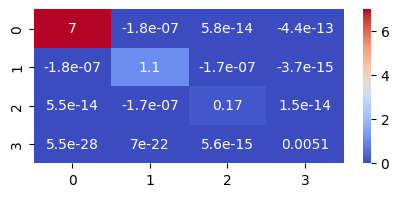

residuals=[-5.329e-15 -2.665e-14  3.139e-14  0.000e+00]


In [358]:
A_ = QR_iteration(A)
evalues_np, evectors = ordered_eigh(A_)

print("A_=")
sns.heatmap(A_, annot=True, cmap='coolwarm')
plt.show()
print(f"residuals={np.diag(A_)-evalues_np}")

### ギブンス回転

Q.T @ Q=


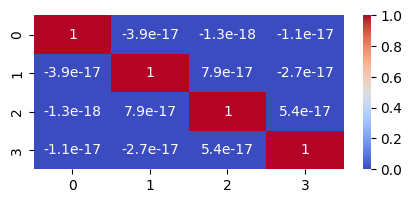

R=


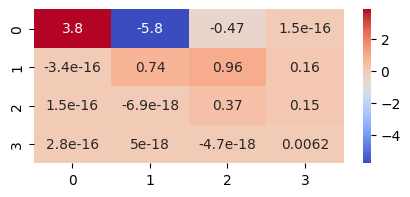

P.T@A@P-QR=


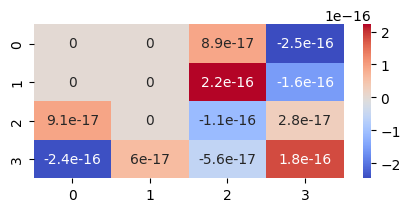

In [359]:
def gibbens_rotation(A, j, eps=1e-6):
  P = np.eye(A.shape[0])
  sin, cos = 0, 0
  norm = np.linalg.norm(A[j:j+2, j])
  if norm > eps:
    sin, cos = A[j+1,j] / norm, A[j,j] / norm
  P[j:j+2, j:j+2] = np.array([[cos, sin], [-sin, cos]])
  return P

def gibbens_QR(A):
  N = A.shape[0]
  R, P = A.copy(), np.eye(N)
  for j in range(N-1):
    P_ = gibbens_rotation(R, j)
    R = P_ @ R
    P = P_ @ P
  return P.T, R

H, P = hessenberg(A)
Q, R = gibbens_QR(H)

print("Q.T @ Q=")
sns.heatmap(Q.T@Q, annot=True, cmap='coolwarm')
plt.show()

print("R=")
sns.heatmap(R, annot=True, cmap='coolwarm')
plt.show()

print("P.T@A@P-QR=")
sns.heatmap(P.T@A@P - Q@R, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
def householder_QR_iteration(A_, eps=1e-6):
  m = A.shape[0] - 1
  H, Ph = hessenberg(A)
  while m > 1:
    if np.abs(A[m, m-1]) < eps:
      m -= 1
      continue

    s = H[m, m]
    Q, R = gibbens_QR(H[:m, :m] - s * np.eye(m))
    H[:m, :m] = R @ Q + s * np.eye(m)
  return H

H = householder_QR_iteration(A)

print("H=")
sns.heatmap(H, annot=True, cmap='coolwarm')
plt.show()

## 特異値分解

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

In [ ]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

In [ ]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

In [ ]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

In [ ]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

In [ ]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [ ]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

$A^TA, AA^T$ の固有値の平方根は特異値

In [ ]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

特異値による行列 $\Sigma$ を作成

In [ ]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

In [ ]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

In [ ]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [ ]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

In [ ]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

In [ ]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')